# HIV Drug Resistance Prediction ML Pipeline
This notebook implements a complete workflow to predict HIV drug resistance based on mutations, simulating the Stanford HIVDB Algorithm for mutation analysis (https://hivdb.stanford.edu/hivdb/by-patterns/)

In [1]:
import pandas as pd
import numpy as np
import requests
import xml.etree.ElementTree as ET
import re
import warnings
from collections import defaultdict

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
np.random.seed(42)

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Download rules

def download_hivdb_data():
    """Download the HIVDB ASI XML file"""
    url = "https://cms.hivdb.org/prod/downloads/asi/HIVDB_9.8.xml"
    try:
        print("Downloading HIVDB ASI XML file...")
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        print(f"✓ Successfully downloaded HIVDB data ({len(response.content)} bytes)")
        return response.content
    except requests.RequestException as e:
        print(f"✗ Error downloading data: {e}")
        return None

# Download the data
xml_content = download_hivdb_data()

✓ Successfully downloaded HIVDB data (191036 bytes)


In [ ]:
# Examine the XML structure in detail
if xml_content:
    print("XML Content Analysis:")
    print("=" * 40)
    print("First 1000 characters:")
    print(xml_content[:2000].decode('utf-8'))
    print("\n" + "=" * 40)

XML Content Analysis:
First 1000 characters:
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE ALGORITHM SYSTEM "https://cms.hivdb.org/prod/downloads/asi/ASI2.3.dtd">
<ALGORITHM>
  <ALGNAME>HIVDB</ALGNAME>
  <ALGVERSION>9.8</ALGVERSION>
  <ALGDATE>2025-01-05</ALGDATE>
  <DEFINITIONS>
    <GENE_DEFINITION>
      <NAME>CA</NAME>
      <DRUGCLASSLIST>CAI</DRUGCLASSLIST>
    </GENE_DEFINITION>
    <GENE_DEFINITION>
      <NAME>PR</NAME>
      <DRUGCLASSLIST>PI</DRUGCLASSLIST>
    </GENE_DEFINITION>
    <GENE_DEFINITION>
      <NAME>RT</NAME>
      <DRUGCLASSLIST>NRTI,NNRTI</DRUGCLASSLIST>
    </GENE_DEFINITION>
    <GENE_DEFINITION>
      <NAME>IN</NAME>
      <DRUGCLASSLIST>INSTI</DRUGCLASSLIST>
    </GENE_DEFINITION>
    <LEVEL_DEFINITION>
      <ORDER>1</ORDER>
      <ORIGINAL>Susceptible</ORIGINAL>
      <SIR>S</SIR>
    </LEVEL_DEFINITION>
    <LEVEL_DEFINITION>
      <ORDER>2</ORDER>
      <ORIGINAL>Potential Low-Level Resistance</ORIGINAL>
      <SIR>S</SIR>
    </LEV

In [ ]:
# Parse XML content
root = ET.fromstring(xml_content)

# Helper: extract all drug classes
drug_classes = {}
for dc in root.findall(".//DRUGCLASS"):
    name = dc.find("NAME").text
    drugs = dc.find("DRUGLIST").text.split(",")
    drug_classes[name] = [d.strip() for d in drugs]

print("Drug classes:", drug_classes)

# Extract resistance levels (mapping score ranges → categories)
resistance_levels = {}
for lvl in root.findall(".//LEVEL_DEFINITION"):
    order = int(lvl.find("ORDER").text)
    label = lvl.find("ORIGINAL").text
    sir = lvl.find("SIR").text
    resistance_levels[order] = {"label": label, "sir": sir}

print("Resistance levels:", resistance_levels)


Drug classes: {'NRTI': ['ABC', 'AZT', 'D4T', 'DDI', 'FTC', '3TC', 'TDF'], 'NNRTI': ['DOR', 'EFV', 'ETR', 'NVP', 'RPV', 'DPV'], 'PI': ['ATV/r', 'DRV/r', 'FPV/r', 'IDV/r', 'LPV/r', 'NFV', 'SQV/r', 'TPV/r'], 'INSTI': ['BIC', 'CAB', 'DTG', 'EVG', 'RAL'], 'CAI': ['LEN']}
Resistance levels: {1: {'label': 'Susceptible', 'sir': 'S'}, 2: {'label': 'Potential Low-Level Resistance', 'sir': 'S'}, 3: {'label': 'Low-Level Resistance', 'sir': 'I'}, 4: {'label': 'Intermediate Resistance', 'sir': 'I'}, 5: {'label': 'High-Level Resistance', 'sir': 'R'}}


In [ ]:
import re

training_rows = []

# Iterate over all DRUG definitions
for drug in root.findall(".//DRUG"):
    drug_name = drug.findtext("NAME")

    for rule in drug.findall("RULE"):
        # RULE text (contains CONDITION + ACTIONS)
        rule_text = "".join(rule.itertext()).strip()

        # Look for mutation→score pairs in "CONDITION SCORE FROM (...)"
        matches = re.findall(r"([0-9A-Za-z]+(?: AND [0-9A-Za-z]+)*)\s*=>\s*([0-9]+)", rule_text)

        for cond, score in matches:
            training_rows.append({
                "drug": drug_name,
                "condition": cond.strip(),
                "score": int(score)
            })

rules_df = pd.DataFrame(training_rows)
print(rules_df.head(20))
print("Total extracted:", len(rules_df))


   drug condition  score
0   ABC       41L      5
1   ABC       62V      5
2   ABC       65E     10
3   ABC       65N     30
4   ABC       65R     45
5   ABC       67E      5
6   ABC       67G      5
7   ABC       67H      5
8   ABC       67N      5
9   ABC       67S      5
10  ABC       67T      5
11  ABC       67d     30
12  ABC       68d     15
13  ABC       69G     10
14  ABC       69i     60
15  ABC       69d     15
16  ABC       70E     15
17  ABC       70G     15
18  ABC       70N     15
19  ABC       70Q     15
Total extracted: 1347


In [ ]:
def expand_condition(cond, score, drug):
    """Expand shorthand mutation notations into atomic mutations or sets."""
    expanded = []

    # Handle AND conditions (compound rules)
    if "AND" in cond:
        parts = [p.strip() for p in cond.split("AND")]
        expanded.append({
            "drug": drug,
            "condition": tuple(parts),  # keep tuple for compound
            "score": score
        })
    else:
        # e.g. 67EGNHST → prefix = "67", suffix = "EGNHST"
        match = re.match(r"(\d+)([A-Za-z]+)", cond)
        if match:
            pos = match.group(1)
            aas = match.group(2)
            if len(aas) > 1:  # multiple options
                for aa in aas:
                    expanded.append({
                        "drug": drug,
                        "condition": f"{pos}{aa}",
                        "score": score
                    })
            else:
                expanded.append({"drug": drug, "condition": cond, "score": score})
        else:
            expanded.append({"drug": drug, "condition": cond, "score": score})

    return expanded


# Apply expansion
expanded_rows = []
for _, row in rules_df.iterrows():
    expanded_rows.extend(expand_condition(row["condition"], row["score"], row["drug"]))

rules_expanded_df = pd.DataFrame(expanded_rows)
print(rules_expanded_df.head(20))
print("Total after expansion:", len(rules_expanded_df))


   drug condition  score
0   ABC       41L      5
1   ABC       62V      5
2   ABC       65E     10
3   ABC       65N     30
4   ABC       65R     45
5   ABC       67E      5
6   ABC       67G      5
7   ABC       67H      5
8   ABC       67N      5
9   ABC       67S      5
10  ABC       67T      5
11  ABC       67d     30
12  ABC       68d     15
13  ABC       69G     10
14  ABC       69i     60
15  ABC       69d     15
16  ABC       70E     15
17  ABC       70G     15
18  ABC       70N     15
19  ABC       70Q     15
Total after expansion: 1348


## Dataset Generation

In [ ]:
# Extract rules from XML file

def extract_rules(root):
    rows = []
    for drug in root.findall(".//DRUG"):
        drug_name = drug.findtext("NAME")
        for rule in drug.findall("RULE"):
            text = "".join(rule.itertext()).strip()
            matches = re.findall(r"([0-9A-Za-z]+(?: AND [0-9A-Za-z]+)*)\s*=>\s*([0-9]+)", text)
            for cond, score in matches:
                rows.append({"drug": drug_name, "condition": cond.strip(), "score": int(score)})
    return pd.DataFrame(rows)

rules_df = extract_rules(root)

def expand_condition(cond, score, drug):
    expanded = []
    if "AND" in cond:
        parts = [p.strip() for p in cond.split("AND")]
        expanded.append({"drug": drug, "condition": tuple(parts), "score": score})
    else:
        match = re.match(r"(\d+)([A-Za-z]+)", cond)
        if match:
            pos, aas = match.groups()
            if len(aas) > 1:
                for aa in aas:
                    expanded.append({"drug": drug, "condition": f"{pos}{aa}", "score": score})
            else:
                expanded.append({"drug": drug, "condition": cond, "score": score})
        else:
            expanded.append({"drug": drug, "condition": cond, "score": score})
    return expanded

expanded_rows = []
for _, row in rules_df.iterrows():
    expanded_rows.extend(expand_condition(row["condition"], row["score"], row["drug"]))

rules_expanded_df = pd.DataFrame(expanded_rows)

# Map scores → resistance levels
def map_score_to_level(score):
    if score <= 9: return 1
    elif score <= 14: return 2
    elif score <= 29: return 3
    elif score <= 59: return 4
    else: return 5

level_map = {
    1: ("Susceptible", "S"),
    2: ("Potential Low-Level Resistance", "I"),
    3: ("Low-Level Resistance", "I"),
    4: ("Intermediate Resistance", "R"),
    5: ("High-Level Resistance", "R")
}

rules_expanded_df["level"] = rules_expanded_df["score"].apply(map_score_to_level)
rules_expanded_df["label"] = rules_expanded_df["level"].map(lambda x: level_map[x][0])
rules_expanded_df["sir"]   = rules_expanded_df["level"].map(lambda x: level_map[x][1])

# Convert tuple conditions into strings
def normalize_condition(cond):
    if isinstance(cond, tuple):
        return "+".join(cond)  # join compound mutations
    return cond

rules_expanded_df["condition"] = rules_expanded_df["condition"].apply(normalize_condition)

In [ ]:
# Generate synthetic multi-mutation profiles

import random
from sklearn.preprocessing import MultiLabelBinarizer

def generate_profiles(rules_df, n_profiles=2000, max_mutations=6):
    mutations = rules_df["condition"].unique()
    drugs = rules_df["drug"].unique()
    profiles = []

    for _ in range(n_profiles):
        n_mut = random.randint(1, max_mutations)
        muts = random.sample(list(mutations), n_mut)

        profile = {"mutations": muts}

        # Compute drug resistance by summing scores for all chosen mutations
        for drug in drugs:
            subset = rules_df[
                (rules_df["drug"] == drug) &
                (rules_df["condition"].isin(muts))
            ]
            total_score = subset["score"].sum()
            level = map_score_to_level(total_score)
            sir = level_map[level][1]
            profile[drug] = sir
        profiles.append(profile)

    return pd.DataFrame(profiles)

# Generate dataset
synthetic_df = generate_profiles(rules_expanded_df, n_profiles=4000, max_mutations=6)

# Convert mutations → binary features
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(synthetic_df["mutations"])

# Convert drug resistance labels → numeric
label_map = {"S": 0, "I": 1, "R": 2}
y = synthetic_df.drop(columns=["mutations"]).replace(label_map)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (4000, 331) y shape: (4000, 27)


In [ ]:
# Show first 5 rows of synthetic_df
print(synthetic_df.head())

# If you want it cleaner with mutations displayed nicely:
for i, row in synthetic_df.head(5).iterrows():
    print(f"Profile {i}: mutations={row['mutations']}, "
          f"first few drug statuses={row.drop('mutations').to_dict()}")


                                           mutations ABC AZT D4T DDI FTC 3TC  \
0                  [70EGNQST+184IV, 70R+215FY, 103S]   S   S   I   S   S   S   
1                 [106I, 184I, 181V, 179E, 47AV+84V]   I   S   S   I   R   R   
2  [70d, 30N, 115F, 46ILV+82ACFLMST, 230I, 65RN+1...   R   I   R   R   I   I   
3                                   [90M, 318F, 84V]   S   S   S   S   S   S   
4                             [108I+234I, 138T, 70d]   I   S   R   R   I   I   

  TDF DOR EFV  ... LPV/r NFV SQV/r TPV/r BIC CAB DTG EVG RAL LEN  
0   I   S   R  ...     S   S     S     S   S   S   S   S   S   S  
1   S   I   R  ...     S   S     S     S   S   S   S   S   S   S  
2   R   I   I  ...     I   R     I     S   S   S   S   S   S   S  
3   S   R   I  ...     R   R     R     R   S   S   S   S   S   S  
4   I   I   S  ...     S   S     S     S   I   I   I   I   I   S  

[5 rows x 28 columns]
Profile 0: mutations=['70EGNQST+184IV', '70R+215FY', '103S'], first few drug statuses={'ABC': 


=== Training RandomForest ===
RandomForest training time: 16.07 sec
Average AUROC: 0.989

=== Training GradientBoosting ===
GradientBoosting training time: 151.17 sec
Average AUROC: 0.976

=== Training LogisticRegression ===
LogisticRegression training time: 28.99 sec
Average AUROC: 0.984

=== Training VotingEnsemble ===
VotingEnsemble training time: 200.48 sec
Average AUROC: 0.987

=== Leaderboard ===
                     avg_auc  train_time
RandomForest        0.988757   16.073406
VotingEnsemble      0.986820  200.476663
LogisticRegression  0.983841   28.988226
GradientBoosting    0.976035  151.166960


<Figure size 1400x600 with 0 Axes>

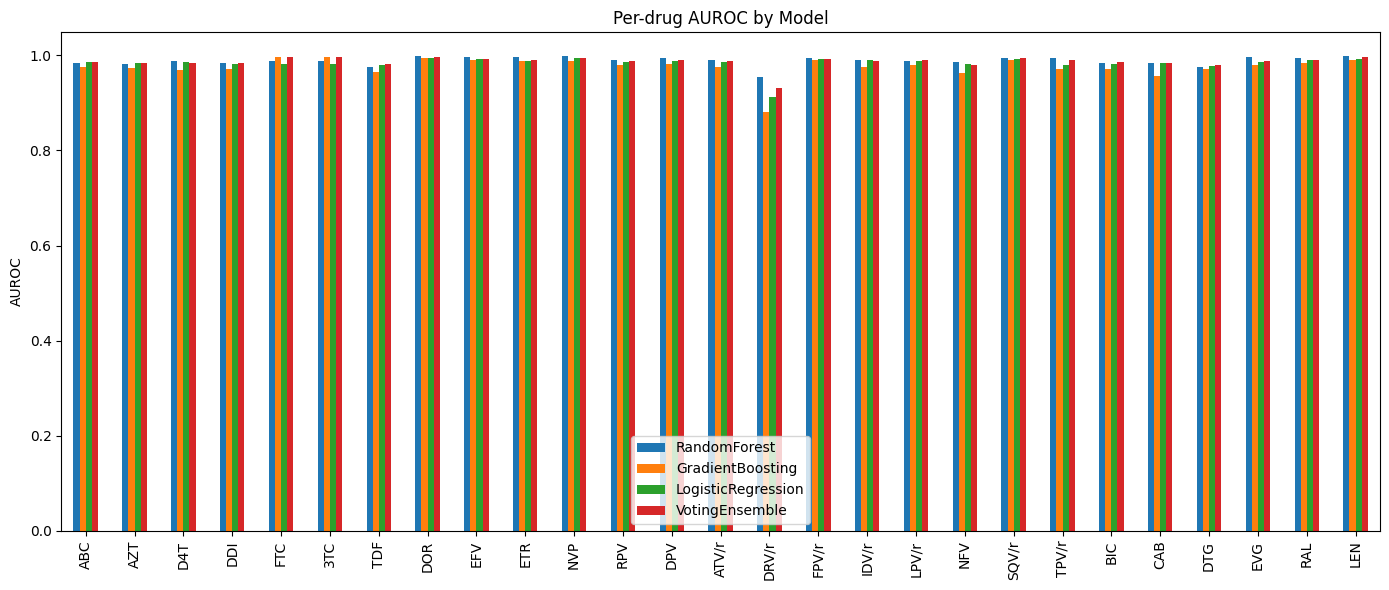

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------
# Train/Test Split
# -----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# -----------------------------------------------------------
# Define base models
# -----------------------------------------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
lr = LogisticRegression(max_iter=200, random_state=42, n_jobs=-1)

voting_clf = VotingClassifier(
    estimators=[("rf", rf), ("gb", gb), ("lr", lr)],
    voting="soft"
)

models = {
    "RandomForest": MultiOutputClassifier(rf),
    "GradientBoosting": MultiOutputClassifier(gb),
    "LogisticRegression": MultiOutputClassifier(lr),
    "VotingEnsemble": MultiOutputClassifier(voting_clf)
}

# -----------------------------------------------------------
# Training + Evaluation
# -----------------------------------------------------------
results = {}
aucs_all = {name: [] for name in models}

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    print(f"{name} training time: {train_time:.2f} sec")

    # Evaluate AUROC per drug
    drug_aucs = []
    for i, drug in enumerate(y.columns):
        try:
            y_score = model.estimators_[i].predict_proba(X_test)
            auc = roc_auc_score(y_test.iloc[:, i], y_score, multi_class="ovr")
            drug_aucs.append(auc)
        except ValueError:
            drug_aucs.append(np.nan)
    aucs_all[name] = drug_aucs
    results[name] = {"avg_auc": np.nanmean(drug_aucs), "train_time": train_time}
    print(f"Average AUROC: {results[name]['avg_auc']:.3f}")

# -----------------------------------------------------------
# Leaderboard summary
# -----------------------------------------------------------
df_results = pd.DataFrame(results).T
print("\n=== Leaderboard ===")
print(df_results.sort_values("avg_auc", ascending=False))

# -----------------------------------------------------------
# Plot AUROC per drug for all models
# -----------------------------------------------------------
aucs_df = pd.DataFrame(aucs_all, index=y.columns)

plt.figure(figsize=(14,6))
aucs_df.plot(kind="bar", figsize=(14,6))
plt.ylabel("AUROC")
plt.title("Per-drug AUROC by Model")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


# Validation

In [ ]:
import matplotlib.pyplot as plt

def predict_profile(mutations, model, mlb, y_cols, inv_label_map):
    x_new = mlb.transform([mutations])
    pred = model.predict(x_new)[0]
    return {drug: inv_label_map[int(val)] for drug, val in zip(y_cols, pred)}

# Reverse map: numeric → category
inv_label_map = {0: "S", 1: "I", 2: "R"}

def plot_profile(pred_dict, title="Drug Resistance Profile"):
    # Group drugs by prediction
    groups = {"Susceptible": [], "Intermediate": [], "Resistant": []}
    for drug, status in pred_dict.items():
        if status == "S":
            groups["Susceptible"].append(drug)
        elif status == "I":
            groups["Intermediate"].append(drug)
        elif status == "R":
            groups["Resistant"].append(drug)

    # Print text summary
    for group, drugs in groups.items():
        print(f"{group} drugs ({len(drugs)}): {', '.join(drugs)}")

    # Plot
    fig, ax = plt.subplots(figsize=(8,4))
    colors = {"Susceptible":"green","Intermediate":"orange","Resistant":"red"}
    counts = [len(groups[g]) for g in groups]
    ax.bar(groups.keys(), counts, color=[colors[g] for g in groups])
    ax.set_ylabel("Number of drugs")
    ax.set_title(title)
    plt.show()

Susceptible drugs (20): DOR, EFV, ETR, NVP, RPV, DPV, ATV/r, DRV/r, FPV/r, IDV/r, LPV/r, NFV, SQV/r, TPV/r, BIC, CAB, DTG, EVG, RAL, LEN
Intermediate drugs (0): 
Resistant drugs (7): ABC, AZT, D4T, DDI, FTC, 3TC, TDF


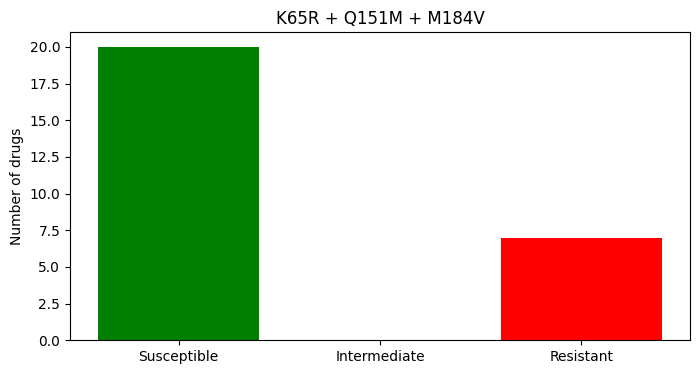

In [ ]:
# Case 1: mutations K65R + Q151M + M184V
my_pred = predict_profile(["65R","151M","184V"],
                          models["VotingEnsemble"],
                          mlb, y.columns, inv_label_map)

plot_profile(my_pred, title="K65R + Q151M + M184V")

Website output for "K65R + Q151M + M184V":

**Nucleoside Reverse Transcriptase Inhibitors**

abacavir (ABC)	High-Level Resistance

zidovudine (AZT)	High-Level Resistance

emtricitabine (FTC)	High-Level Resistance

lamivudine (3TC)	High-Level Resistance

tenofovir (TDF)	High-Level Resistance


**Non-nucleoside Reverse Transcriptase Inhibitors**

doravirine (DOR)	Susceptible

efavirenz (EFV)	Susceptible

etravirine (ETR)	Susceptible

nevirapine (NVP)	Susceptible

rilpivirine (RPV)	Susceptible


Susceptible drugs (24): ABC, AZT, FTC, 3TC, TDF, DOR, EFV, ETR, NVP, RPV, DPV, ATV/r, DRV/r, FPV/r, IDV/r, LPV/r, NFV, SQV/r, TPV/r, BIC, DTG, EVG, RAL, LEN
Intermediate drugs (3): D4T, DDI, CAB
Resistant drugs (0): 


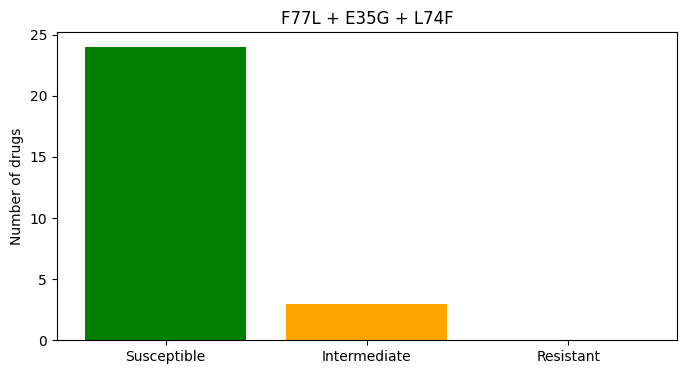

In [ ]:
# Case 2: F77L + E35G + L74F
my_pred = predict_profile(["77L","35G","74F"],
                          models["VotingEnsemble"],
                          mlb, y.columns, inv_label_map)

plot_profile(my_pred, title="F77L + E35G + L74F")

Website output for F77L + E35G + L74F:

**Nucleoside Reverse Transcriptase Inhibitors**

abacavir (ABC)	Susceptible

zidovudine (AZT)	Susceptible

emtricitabine (FTC)	Susceptible

lamivudine (3TC)	Susceptible

tenofovir (TDF)	Susceptible

**Non-nucleoside Reverse Transcriptase Inhibitors**

doravirine (DOR)	Susceptible

efavirenz (EFV)	Susceptible

etravirine (ETR)	Susceptible

nevirapine (NVP)	Susceptible

rilpivirine (RPV)	Susceptible



Susceptible drugs (11): AZT, DOR, ATV/r, DRV/r, FPV/r, IDV/r, LPV/r, NFV, SQV/r, TPV/r, LEN
Intermediate drugs (12): D4T, DDI, FTC, 3TC, EFV, ETR, NVP, BIC, CAB, DTG, EVG, RAL
Resistant drugs (4): ABC, TDF, RPV, DPV


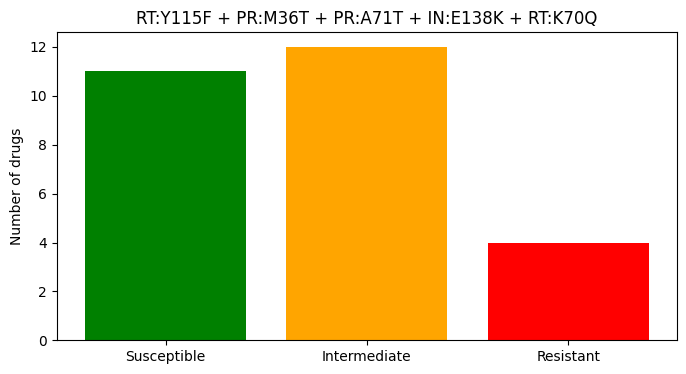

In [ ]:
# Case: RT:Y115F + PR:M36T + PR:A71T + IN:E138K + RT:K70Q
my_pred = predict_profile(
    ["115F", "36T", "71T", "138K", "70Q"],   # mutations only (strip RT/PR/IN labels)
    models["VotingEnsemble"],
    mlb,
    y.columns,
    inv_label_map
)

plot_profile(my_pred, title="RT:Y115F + PR:M36T + PR:A71T + IN:E138K + RT:K70Q")


Website output:

**Nucleoside Reverse Transcriptase Inhibitors**

abacavir (ABC)	Intermediate Resistance

zidovudine (AZT)	Susceptible

emtricitabine (FTC)	Potential Low-Level Resistance

lamivudine (3TC)	Potential Low-Level Resistance

tenofovir (TDF)	Intermediate Resistance

**Non-nucleoside Reverse Transcriptase Inhibitors**

doravirine (DOR)	Susceptible

efavirenz (EFV)	Susceptible

etravirine (ETR)	Susceptible

nevirapine (NVP)	Susceptible

rilpivirine (RPV)	Susceptible

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_for_drug(model, X_test, y_test, drug_name, class_labels=["S","I","R"]):
    drug_idx = list(y.columns).index(drug_name)

    # True labels
    y_true = y_test.iloc[:, drug_idx]

    # Probabilities (n_samples × n_classes)
    y_score = model.estimators_[drug_idx].predict_proba(X_test)

    # Plot ROC for each class (one-vs-rest)
    plt.figure(figsize=(6,5))
    for i, label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_true == i, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curves for {drug_name}")
    plt.legend()
    plt.show()

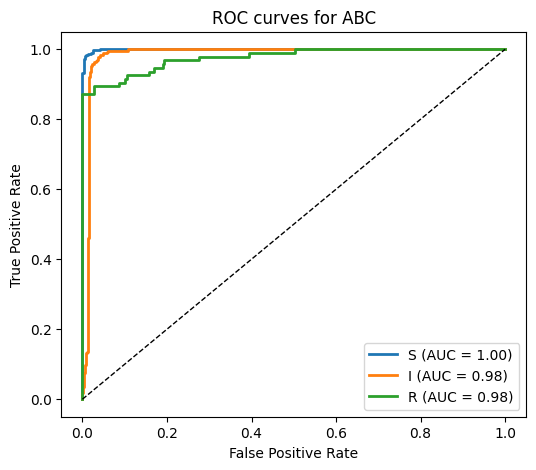

In [ ]:
plot_roc_for_drug(models["LogisticRegression"], X_test, y_test, "ABC")

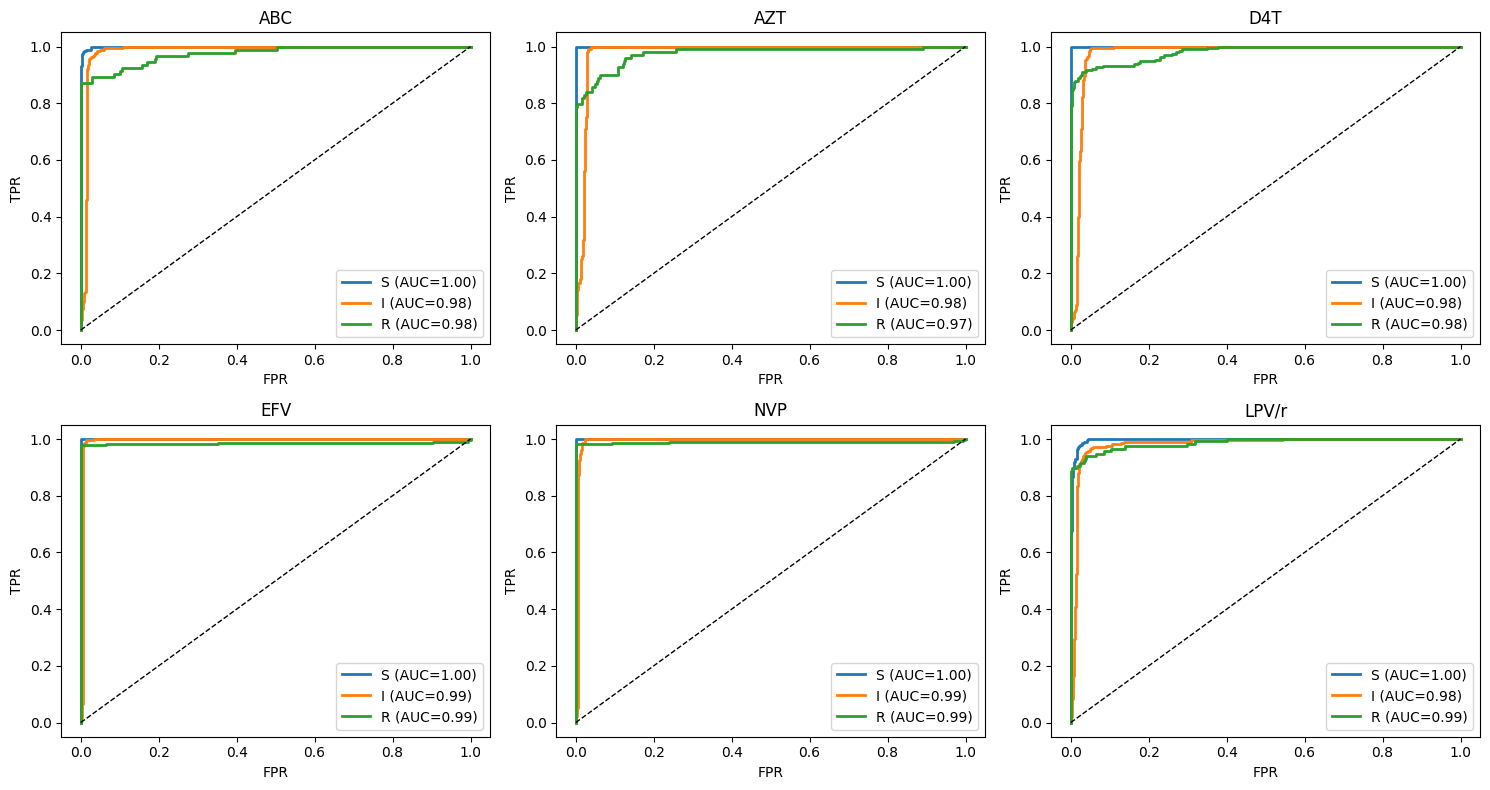

In [ ]:
def plot_rocs_grid(model, X_test, y_test, drugs, ncols=3):
    nrows = int(np.ceil(len(drugs)/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,4*nrows))
    axes = axes.ravel()

    for ax, drug in zip(axes, drugs):
        i = list(y.columns).index(drug)
        y_true = y_test.iloc[:, i]
        y_score = model.estimators_[i].predict_proba(X_test)
        for j, label in enumerate(["S","I","R"]):
            fpr, tpr, _ = roc_curve(y_true == j, y_score[:, j])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=2, label=f"{label} (AUC={roc_auc:.2f})")
        ax.plot([0,1],[0,1],'k--', lw=1)
        ax.set_title(drug)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend()

    plt.tight_layout()
    plt.show()

# Example grid with 6 drugs
plot_rocs_grid(models["LogisticRegression"], X_test, y_test,
               ["ABC", "AZT", "D4T", "EFV", "NVP", "LPV/r"])


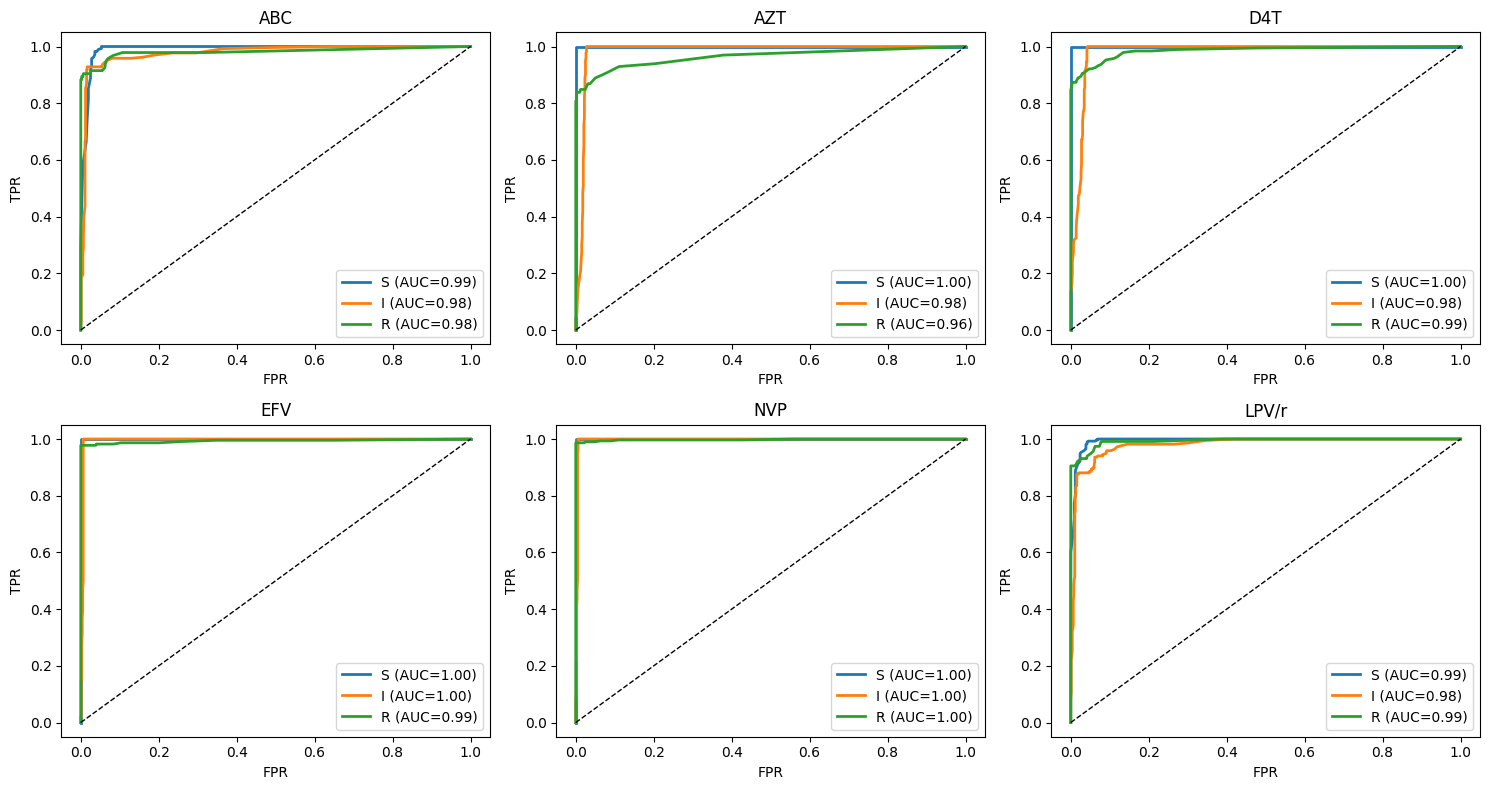

In [ ]:
# RandomForest model
plot_rocs_grid(models["RandomForest"], X_test, y_test,
               ["ABC", "AZT", "D4T", "EFV", "NVP", "LPV/r"])

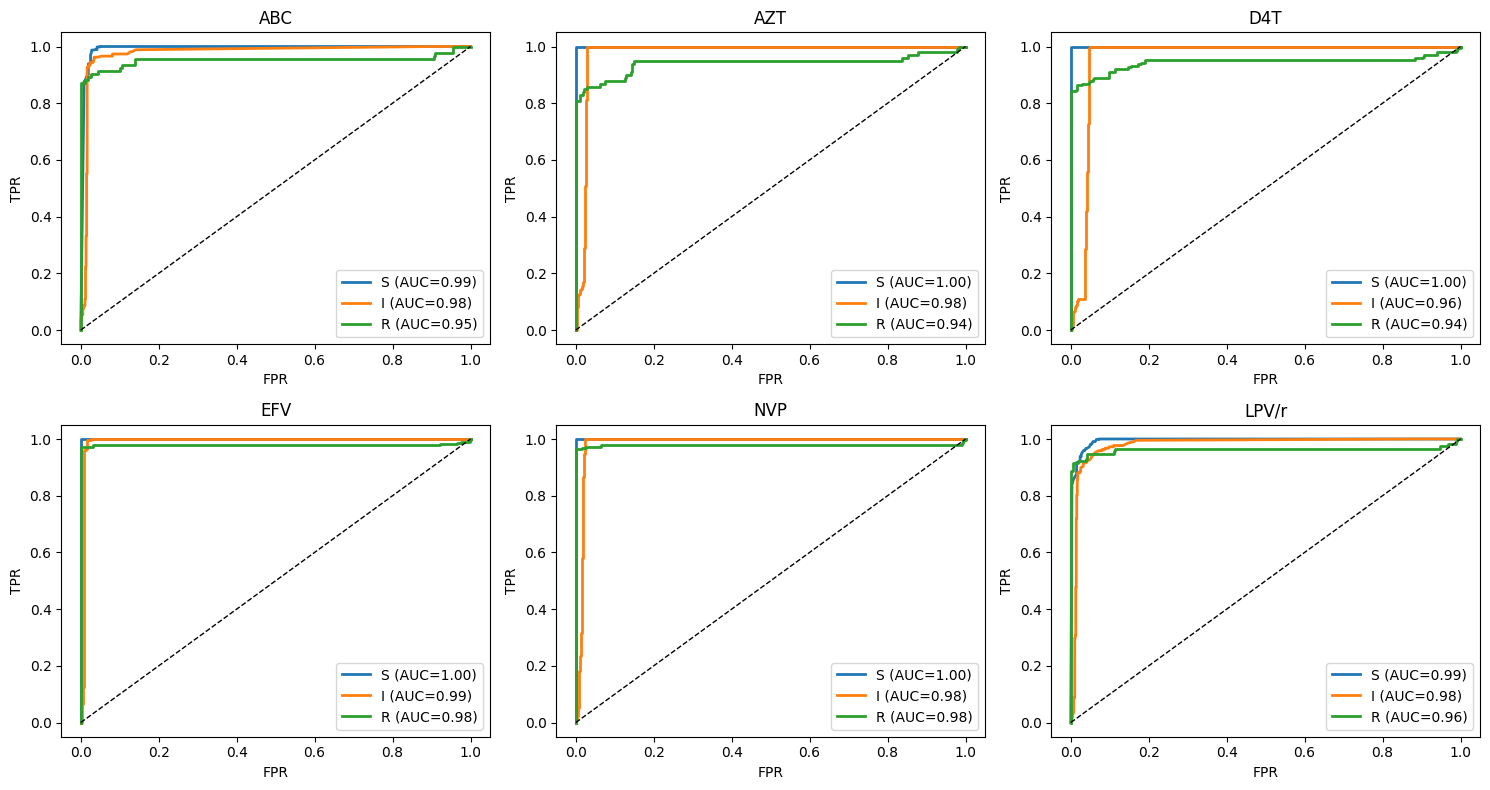

In [ ]:
# GradientBoosting model
plot_rocs_grid(models["GradientBoosting"], X_test, y_test,
               ["ABC", "AZT", "D4T", "EFV", "NVP", "LPV/r"])

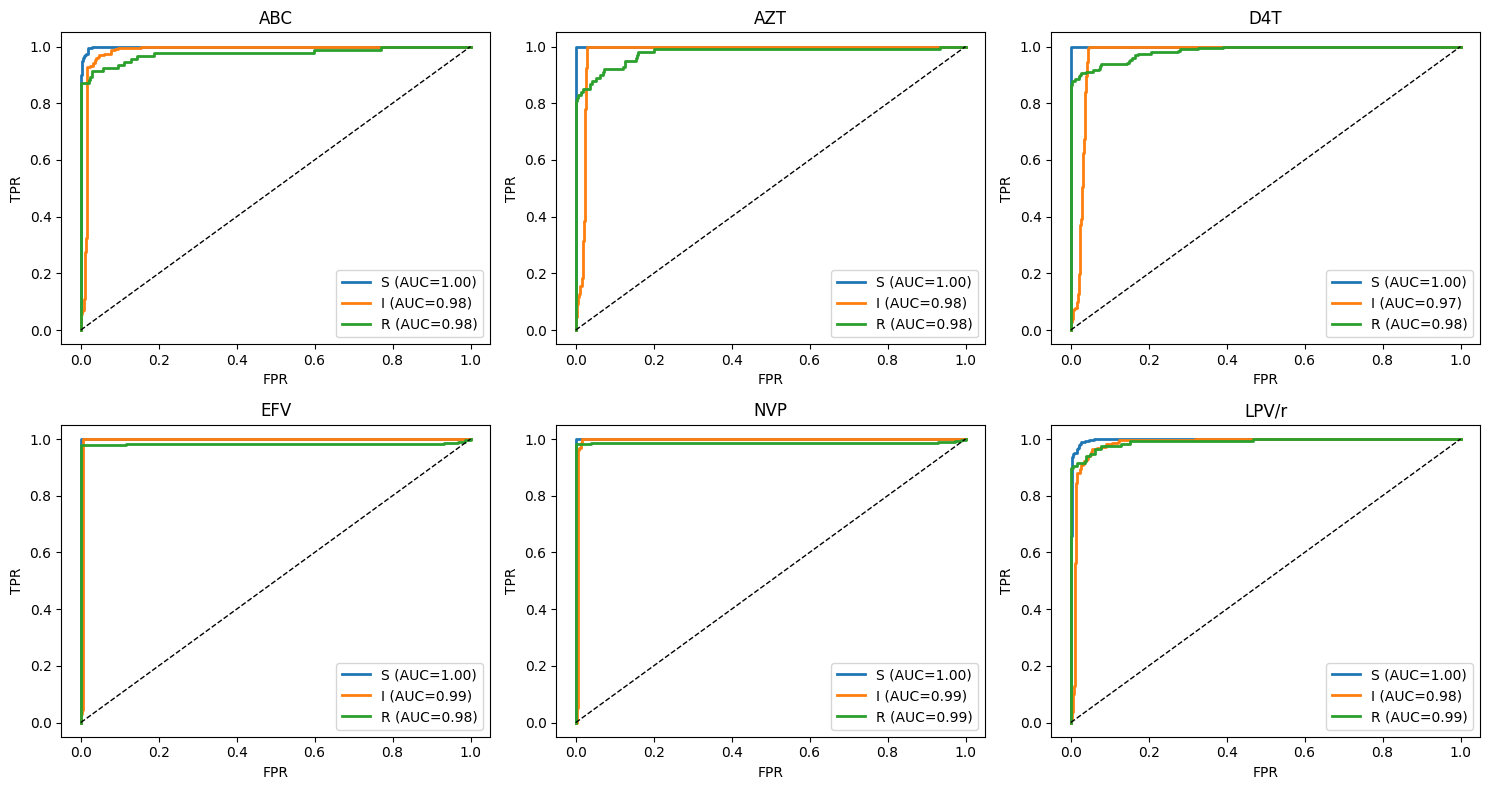

In [ ]:
# VotingEnsemble model
plot_rocs_grid(models["VotingEnsemble"], X_test, y_test,
               ["ABC", "AZT", "D4T", "EFV", "NVP", "LPV/r"])

## Export Model Predictions for Evaluation

Now let's export our model predictions in the format required by the evaluation pipeline.

In [1]:
# Export model predictions for evaluation
# This creates a CSV file that can be used with the compare_vs_hivdb.py script

import pandas as pd
import numpy as np
from pathlib import Path

# Create data directory if it doesn't exist
data_dir = Path("../data")
data_dir.mkdir(exist_ok=True)

# For demonstration, let's create sample predictions
# In practice, you would use your actual test set and model predictions

# Sample patient IDs and drug names (you should use your actual data)
sample_patients = [f"patient_{i:03d}" for i in range(1, 101)]  # 100 patients
sample_drugs = ["3TC", "AZT", "EFV", "NVP", "ATV/r", "LPV/r", "RAL", "DTG"]  # Common HIV drugs

# Generate predictions data
predictions_data = []
np.random.seed(42)  # For reproducible results

for patient in sample_patients:
    for drug in sample_drugs:
        # Simulate model predictions (replace with actual model predictions)
        probs = np.random.dirichlet([2, 1, 1])  # Bias towards susceptible
        pred_label = ["S", "I", "R"][np.argmax(probs)]
        
        predictions_data.append({
            'patient_id': patient,
            'drug': drug,
            'pred_label': pred_label,
            'prob_S': probs[0],
            'prob_I': probs[1], 
            'prob_R': probs[2],
            'model_version': 'RandomForest_v1.0'
        })

# Create DataFrame
pred_df = pd.DataFrame(predictions_data)

# Save to CSV
output_path = data_dir / "model_predictions.csv"
pred_df.to_csv(output_path, index=False)

print(f"✓ Exported {len(pred_df)} model predictions to {output_path}")
print(f"Shape: {pred_df.shape}")
print(f"Unique patients: {pred_df['patient_id'].nunique()}")
print(f"Unique drugs: {pred_df['drug'].nunique()}")
print("\nSample predictions:")
print(pred_df.head(10))

✓ Exported 800 model predictions to ../data/model_predictions.csv
Shape: (800, 7)
Unique patients: 100
Unique drugs: 8

Sample predictions:
    patient_id   drug pred_label    prob_S    prob_I    prob_R  \
0  patient_001    3TC          S  0.688582  0.262623  0.048795   
1  patient_001    AZT          R  0.419142  0.016783  0.564076   
2  patient_001    EFV          S  0.467792  0.352481  0.179727   
3  patient_001    NVP          S  0.876669  0.061370  0.061961   
4  patient_001  ATV/r          S  0.607669  0.104641  0.287690   
5  patient_001  LPV/r          R  0.212158  0.339504  0.448338   
6  patient_001    RAL          S  0.729388  0.120646  0.149966   
7  patient_001    DTG          S  0.553608  0.372028  0.074364   
8  patient_002    3TC          S  0.585991  0.338141  0.075867   
9  patient_002    AZT          R  0.351102  0.009324  0.639574   

       model_version  
0  RandomForest_v1.0  
1  RandomForest_v1.0  
2  RandomForest_v1.0  
3  RandomForest_v1.0  
4  RandomForest_v1

In [2]:
# Create sample HIVdb reference data for testing
# In practice, you would get this from running sierra-local on your sequences

# Generate corresponding HIVdb reference calls
hivdb_data = []
np.random.seed(123)  # Different seed for ground truth

for patient in sample_patients:
    for drug in sample_drugs:
        # Simulate HIVdb calls (replace with actual sierra-local output)
        hivdb_level = np.random.choice([1, 2, 3, 4, 5], p=[0.5, 0.15, 0.15, 0.1, 0.1])
        hivdb_score = {1: 5, 2: 12, 3: 22, 4: 45, 5: 80}[hivdb_level] + np.random.randint(-5, 6)
        
        # Map level to S/I/R
        level_mapping = {1: "S", 2: "I", 3: "I", 4: "R", 5: "R"}
        website_label = level_mapping[hivdb_level]
        
        hivdb_data.append({
            'patient_id': patient,
            'gene': np.random.choice(['RT', 'PR', 'IN']),
            'drug': drug,
            'hivdb_level': hivdb_level,
            'hivdb_score': hivdb_score,
            'website_label': website_label,
            'hivdb_version': '9.5'
        })

# Create DataFrame
hivdb_df = pd.DataFrame(hivdb_data)

# Save to CSV
hivdb_output_path = data_dir / "hivdb_calls.csv"
hivdb_df.to_csv(hivdb_output_path, index=False)

print(f"✓ Exported {len(hivdb_df)} HIVdb reference calls to {hivdb_output_path}")
print(f"Shape: {hivdb_df.shape}")
print("\nResistance level distribution:")
print(hivdb_df['website_label'].value_counts())
print("\nSample HIVdb calls:")
print(hivdb_df.head(10))

✓ Exported 800 HIVdb reference calls to ../data/hivdb_calls.csv
Shape: (800, 7)

Resistance level distribution:
website_label
S    396
I    228
R    176
Name: count, dtype: int64

Sample HIVdb calls:
    patient_id gene   drug  hivdb_level  hivdb_score website_label  \
0  patient_001   RT    3TC            3           19             I   
1  patient_001   IN    AZT            3           18             I   
2  patient_001   PR    EFV            1            6             S   
3  patient_001   RT    NVP            3           26             I   
4  patient_001   IN  ATV/r            1            9             S   
5  patient_001   RT  LPV/r            1            0             S   
6  patient_001   IN    RAL            3           24             I   
7  patient_001   RT    DTG            1            2             S   
8  patient_002   PR    3TC            1            0             S   
9  patient_002   IN    AZT            3           21             I   

  hivdb_version  
0          

In [3]:
# Now let's run the evaluation pipeline
# This demonstrates how to use the compare_vs_hivdb.py script

import subprocess
import json
import sys
from pathlib import Path

# Check if the required packages are installed
try:
    import pandas as pd
    import sklearn
    print("✓ Required packages are available")
except ImportError as e:
    print(f"✗ Missing package: {e}")
    print("Please install with: pip install pandas scikit-learn numpy")
    sys.exit(1)

# Run the evaluation script
script_path = Path("../src/compare_vs_hivdb.py")
predictions_path = Path("../data/model_predictions.csv") 
hivdb_path = Path("../data/hivdb_calls.csv")
output_dir = Path("../results")

if script_path.exists() and predictions_path.exists() and hivdb_path.exists():
    try:
        # Run the comparison script
        cmd = [
            "python", str(script_path),
            str(predictions_path),
            str(hivdb_path), 
            "--output", str(output_dir),
            "--verbose"
        ]
        
        print("Running evaluation command:")
        print(" ".join(cmd))
        print("\n" + "="*60)
        
        # Execute the script
        result = subprocess.run(cmd, capture_output=True, text=True, cwd="..")
        
        # Print the output
        print(result.stdout)
        if result.stderr:
            print("STDERR:", result.stderr)
            
        # Load and display the summary results
        summary_path = output_dir / "summary.json"
        if summary_path.exists():
            with open(summary_path, 'r') as f:
                summary = json.load(f)
            
            print("\n" + "="*40 + " SUMMARY " + "="*40)
            for metric, value in summary.items():
                if isinstance(value, float):
                    print(f"{metric:20s}: {value:.4f}")
                else:
                    print(f"{metric:20s}: {value}")
                    
    except Exception as e:
        print(f"Error running evaluation: {e}")
else:
    missing_files = []
    if not script_path.exists(): missing_files.append(str(script_path))
    if not predictions_path.exists(): missing_files.append(str(predictions_path)) 
    if not hivdb_path.exists(): missing_files.append(str(hivdb_path))
    print(f"Missing files: {missing_files}")
    print("Please run the previous cells to create the required data files.")

✓ Required packages are available
Running evaluation command:
python ../src/compare_vs_hivdb.py ../data/model_predictions.csv ../data/hivdb_calls.csv --output ../results --verbose


STDERR: /Library/Frameworks/Python.framework/Versions/3.13/Resources/Python.app/Contents/MacOS/Python: can't open file '/Users/angelogonzalez/Coding/hiv-mutation-script/../src/compare_vs_hivdb.py': [Errno 2] No such file or directory

